<a href="https://colab.research.google.com/github/niteshctrl/ml_projects/blob/master/StackOverflow_Tags_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

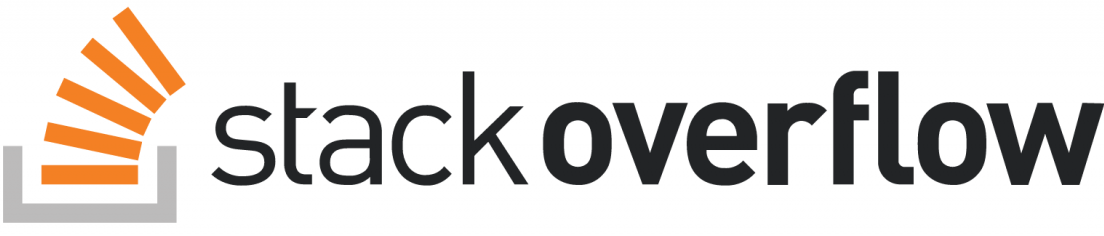
Image Credit: www.stackoverflow.com

# 0 Introduction

### `Task:`
Predict the tags (a.k.a. keywords, topics, summaries), given only the question text and its title. The dataset contains content from disparate stack exchange sites, containing a mix of both technical and non-technical questions.

### `Evaluation Metric:`
The evaluation metric for this project is Mean F1-Score.  The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision P and recall R. Precision is the ratio of true positives (TP) to all predicted positives (TP + FP). Recall is the ratio of true positives to all actual positives (TP + FN). The F1 score is given by:

> F1=2PR / (P + R)

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

The tag predicted must be an exact match, regardless of whether the tags are synonyms. 

* **Why aren't synonyms counted?**

1. Giving out a list of candidate synonyms is a potential source of leakage
2. Synonyms are subjective, and there are "subjectively many" synonyms for a given tag
3. Equally penalized for predicting a synonym of a correct tag, so the task can be framed as not only predicting a tag, but also modeling the distribution(s) of potential synonyms

## Data Description:
Train.csv contains 4 columns: Id,Title,Body,Tags

1. Id - Unique identifier for each question
2. Title - The question's title
3. Body - The body of the question
4. Tags - The tags associated with the question (all lowercase, should not contain tabs '\t' or ampersands '&')
---

Ref : https://medium.com/datadriveninvestor/predicting-tags-for-the-questions-in-stack-overflow-29438367261e

# 1 Data Preparation and Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
!pip install contractions

In [ ]:
# Importing Libraries

import sqlite3
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Preprocessing Libraries
import re
import nltk
import contractions                     # Use pycontractions in future uses
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Featurization Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling Libraries
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

# Metrics Libraries
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
nltk.download('punkt')  # Tokenize
nltk.download('stopwords')

In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
# Extracting the ZIP data files in Google Drive
"""
!unzip /content/gdrive/My\ Drive/datasets/stacko/Train.zip -d /content/gdrive/My\ Drive/datasets/stacko/
!unzip /content/gdrive/My\ Drive/datasets/stacko/Test.zip -d /content/gdrive/My\ Drive/datasets/stacko"""

'\n!unzip /content/gdrive/My\\ Drive/datasets/stacko/Train.zip -d /content/gdrive/My\\ Drive/datasets/stacko/\n!unzip /content/gdrive/My\\ Drive/datasets/stacko/Test.zip -d /content/gdrive/My\\ Drive/datasets/stacko'

In [ ]:
# Loading the data from Google Drive into PANDAS Dataframe

train_df = pd.read_csv('/content/gdrive/My Drive/datasets/stacko/Train.csv')

# 2 Data Cleaning - I(Duplicates Removal)


In [ ]:
train_df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [ ]:
# Check for duplicates

train_df[['Title','Body','Tags']].duplicated().value_counts()

False    4206314
True     1827881
dtype: int64

---

There are a significant number of 'True' values implying 1827881 duplicate rows.

---

In [ ]:
# Duplicate Removal

train_no_dup = train_df[['Title','Body','Tags']].drop_duplicates(ignore_index=True)
train_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4206314 entries, 0 to 6034194
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Title   object
 1   Body    object
 2   Tags    object
dtypes: object(3)
memory usage: 128.4+ MB


---

We are now left with only 4206314 (4.2M) rows which is a reduction of ~30% data rows!!

---

# 3 Exploratory Data Analysis

1. Basic stats(df.info())
2. Duplicate Check
3. Analysis of Class labels

In [ ]:
train_df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034195 entries, 0 to 6034194
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 184.1+ MB


---
Observations:
1. Number of rows = 6034195 (6.03M)
---

## Analysis of Output labels

In [ ]:
# Prepare a single string of tags to plot WordCloud

tags_str = ''
for i in train_no_dup['Tags']:
    tags_str += str(i) + ' '        # Typecast each value to String and concat

In [ ]:
# WordCloud function

def _plot_wcloud(list_words):
    # Ref: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
    wc = WordCloud(width=1000, height=700)
    wc.generate(list_words)
    
    plt.figure(figsize=(10,6))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

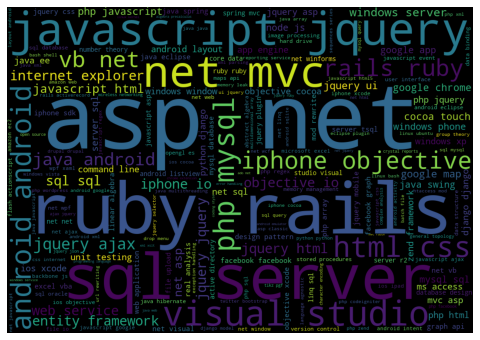

In [ ]:
_plot_wcloud(tags_str)

In [ ]:
# Counting number of tags for each row

tags_count = []
for i in train_no_dup['Tags']:
    tags_count.append(str(i).strip().count(' ') + 1)

In [ ]:
# Appending the list as a column to the dataframe

train_no_dup['tag_count'] = tags_count
train_no_dup.head()                          # Dataframe check

,Title,Body,Tags,tag_count
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


In [ ]:
train_no_dup['Tags'].value_counts()[0:30]

android                   35794
php                       21957
jquery                    19842
javascript                17955
javascript jquery         17923
java                      17296
c#                        16318
python                    11920
php mysql                 11501
c++                       11081
mysql                     10792
html css                   9651
iphone                     8603
asp.net                    8105
ruby-on-rails              7060
c# asp.net                 7056
java android               6336
c                          6186
css                        6132
c# .net                    4349
r                          4320
git                        4152
javascript html            4073
iphone objective-c         4071
javascript jquery html     3713
sql                        3686
objective-c                3641
ruby                       3573
mysql sql                  3509
asp.net-mvc                3442
Name: Tags, dtype: int64

---

Observe that most occuring tags are of length 1 and hence tag dependency is something which can be ignored during Modeling

---

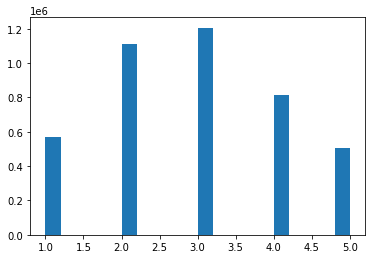

In [ ]:
# (No. of Questions) VS (No. of tags)

plt.hist(tags_count, bins = 20)
plt.show()

In [ ]:
# Number of times each tag appeared

tags = []
for i in train_no_dup['Tags']:
    try:
        tags.extend(i.split())
    except:
        continue
tags = pd.Series(tags)

In [ ]:
tags.value_counts()

c#                   331505
java                 299414
php                  284103
javascript           265423
android              235436
                      ...  
scratch-memory            1
tungsten                  1
phi                       1
conservation-laws         1
flattened                 1
Length: 42048, dtype: int64

In [ ]:
tags.value_counts()[0:20]

c#               331505
java             299414
php              284103
javascript       265423
android          235436
jquery           221533
c++              143936
python           134137
iphone           128681
asp.net          125651
mysql            122769
html             120237
.net             114087
ios              101010
objective-c       95981
sql               95160
css               93745
ruby-on-rails     83487
linux             78670
c                 69169
dtype: int64

In [ ]:
# Total number of unique tags

tags.unique().size

42048

---

This number(42048) is the number of classes to be predicted which will cumbersome to train.

---

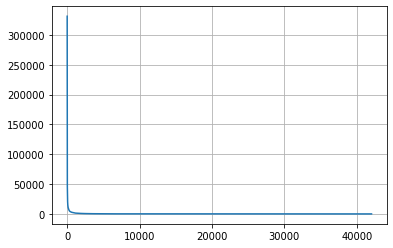

In [ ]:
plt.plot(tags.value_counts().values)
plt.grid()
plt.show()

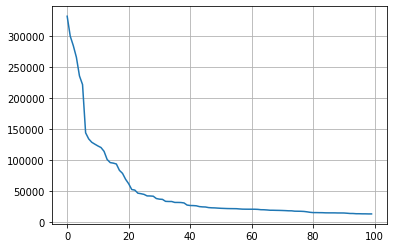

In [ ]:
plt.plot(tags.value_counts().values[0:100])
plt.grid()
plt.show()

In [ ]:
# percentiles and quantiles



In [ ]:
# Tags per question histogram


In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
train_no_dup[['Title','Tags']][0:20]

,Title,Tags
0,How to check if an uploaded file is an image without mime type?,php image-processing file-upload upload mime-types
1,How can I prevent firefox from closing when I press ctrl-w,firefox
2,R Error Invalid type (list) for variable,r matlab machine-learning
3,How do I replace special characters in a URL?,c# url encoding
4,How to modify whois contact details?,php api file-get-contents
5,setting proxy in active directory environment,proxy active-directory jmeter
6,How to draw barplot in this way with Coreplot,core-plot
7,How to fetch an XML feed using asp.net,c# asp.net windows-phone-7
8,.NET library for generating javascript?,.net javascript code-generation
9,"SQL Server : procedure call, inline concatenation impossible?",sql variables parameters procedure calls


# 3 Data Cleaning - II and Preprocessing

1. HTML tags Removal
2. Punctuation Removal
3. Stopwords Removal
4. Stemming(This auto lowercases the words) or Lemmitization
5. Convert to Lowercase
7. Expanding Contractions
8. Treat numbers

In [ ]:
# Preprocessing Functions

"""
def _html_tag_remover(sentence):
    # Ref: https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', sentence).strip()


def _expand_contractions(sentence):
    # Ref: https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b
    # Ref: https://pypi.org/project/pycontractions/
    # TBD-- Use spaCy or pycontractions
    return contractions.fix(sentence)


def _punc_remover(sentence):
    punctuations = '!?#$%^&*,:\;-_(){}/[]'
    for character in sentence:
        if character in punctuations:
            sentence = sentence.replace(character, " ")
            continue
    return sentence.strip()


def _stop_remover(sentence):
    # Ref: https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/
    filtered_sentence = ''
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(sentence)
    for token in tokens:
        if token not in stop_words:
            filtered_sentence += token + ' '
    return filtered_sentence.strip()


def _stemmer(sentence): # This automatically converts to lowercase
    stemmed_sentence = ""
    tokens = word_tokenize(sentence) # str.split() can be used for faster result
    # but take a look: https://stackoverflow.com/questions/35345761/python-re-split-vs-nltk-word-tokenize-and-sent-tokenize
    snow = SnowballStemmer('english')
    for token in tokens:
        stemmed_sentence += snow.stem(token) + ' '
    return stemmed_sentence.strip()


def _lemmatizer(sentence):
    pass


def _treat_numbers(sentence):
    pass
"""

In [ ]:
# Faster Preprocessing without function calls
datapoints = 50000

def _preprocess(train_list):
    """
    Arguments:
    train_list --- A list of unprocessed strings

    Returns:
    filtered_sentences --- A list of processed strings
    """

    filtered_sentences = []
    punctuations = '!?#$%^&*,:\;-_(){}/[]'
    stop_words = set(stopwords.words('english'))
    snow = SnowballStemmer('english')

    for i in tqdm(range(len(train_list))):
        sentence = train_list[i]
        clean = re.compile('<.*?>')
        sentence = re.sub(clean, ' ', sentence).strip() # HTML Removal
        sentence = contractions.fix(sentence)           # Expanding Contractions
        tokens = word_tokenize(sentence)
        temp = ''
        for token in tokens:
            if token not in punctuations:               # Punctuation Removal
                if token not in stop_words:             # Stopword Removal
                    temp += snow.stem(token) + ' '      # Stemming
        filtered_sentences.append(temp.strip())

    return filtered_sentences

In [ ]:
# Driving the above function

X_title = _preprocess(train_no_dup['Title'].iloc[0:datapoints])
X_processed = X_title

y = train_no_dup['Tags'].iloc[0:datapoints]

# 4 Featurization

1. Data Splitting
2. Featurization

In [ ]:
def _featurize_split(X_preprocessed, y, y_max_features, cv_size = 0.2):
    """ 
    Arguments:
    X_preprocessed ---  List of preprocessed text strings to build TfIdf...
    y ---  List of strings with tags to build binary counts
    y_max_features --- Maximum number of tags to consider bases on occurance frequency
    cv_size --- Fraction of input data to split into Cross-Validation set.(default = 0)

    Returns:
    X_featurized --- TfIdf form of each document in the corpus
    Y_featurized --- Binary Bag of Words form of the tags
    vectorizer_tfidf
    """

    # Count Vectorizer for tags(Output Labels)
    vectorizer = CountVectorizer(lowercase=True, binary=True, max_features=y_max_features)
    y_featurized = vectorizer.fit_transform(y)              # Binary Bow

    # Splitting data
    X_train_raw, X_cv_raw, y_train, y_cv = train_test_split\
        (X_preprocessed, y, test_size = cv_size)                

    # TFIDF Vectorizer for training data(X_train)
    vectorizer_tfidf = TfidfVectorizer()
    X_train = vectorizer_tfidf.fit_transform(X_train_raw)
    X_cv = vectorizer_tfidf.transform(X_cv_raw)

    return X_train, X_cv, y_train, y_cv

In [ ]:
# Driving the above function

X_train, X_cv, y_train, y_cv = _featurize_split(X_processed, y, y_max_features = 50, cv_size = .2)

print(X_train.shape)
print(X_cv.shape)

(40000, 16895)
(10000, 16895)


In [ ]:
print(y_train.shape)
print(y_cv.shape)

(50000, 50)

# 5 Model Exploration

1. Naive Bayes
2. Logistic Regresion

We won't go for non-linear models as we will have to train one model for each tag and hence going for the cheaper to train models.

## 5.2 Logistic Regression

In [ ]:
# Logistic Regression function

def _logistic_regression(X_train, X_cv, y_train,  y_cv, _alpha=0.0001):
    """
    Arguments:

    Returns:
    """

    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha = _alpha, n_jobs=-1), n_jobs=-1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_cv)
    f1_micro = f1_score(y_cv, pred, average='micro')
    accuracy = accuracy_score(y_cv, pred)

    return f1_micro, accuracy

In [ ]:
f1, acc = _logistic_regression(X_train, X_cv, y_train, y_cv)
print(f1)
print(acc)

In [ ]:
_logistic_regression(X_train, X_cv, y_train, y_cv)

# 6 Results and Conclusion

